In [1]:
"""
    Import necessary library functions
"""
import numpy as np
from scipy.ndimage import affine_transform
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
"""
    Convenient functions
"""
def display_slice(img_array: np.array, img_slice: int=96):
    """
        Display slice of image
    """
    # make a figure (no axis)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    
    # grab the selected slice to display
    selected_slice = img_array[img_slice,:,:].T
    
    # plot selected slice
    ax.imshow(selected_slice,origin='lower',cmap='gray')

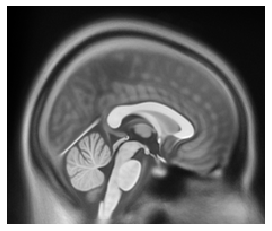

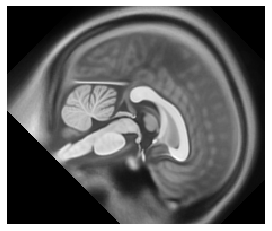

In [3]:
"""
    Read in image data from disk
"""
# We first load in the image data into python using nibabel
# Nibabel automatically reads in the NIFTI header information
# alongside the actual image data
#
# We'll use the affine information in the header to project
# the data onto physical coordiantes from it's array-based
# voxel coordinate representation
#
# NOTE: as a grounf truth the mover image is simply the fixed
# image rotated by 45 degrees on the x-axis
fixed_img = nib.load("fixed.nii.gz")
mover_img = nib.load("mover.nii.gz")

# Display images
display_slice(fixed_img.get_fdata())
display_slice(mover_img.get_fdata())

In [4]:
"""
    Define initial affine transform
"""
# We define an initial 4x4 matrix to start the
# affine registration process. Note that this will
# be the inverse affine matrix (from fixed --> mover)
# rather than the forward affine matrix since we tend to
# interpolation is more easily done on a fixed grid
#
# A general good choice for initialization
# is setting the matrix to identiry
#
# If prior knowledge is known about the transform
# it is possible set the initial affine matrix
# to that
affine_mat = np.eye(4)

# Now we need to account for the physical coordinates of each image
# we will augment the affine matrix with the voxel --> physical
# affines that are in the headers of the fixed and moving images
#
# Since the affine is the inverse transfrom we concatenate the
# matrices by matrix multiplying from fixed_affine -->
# affine_mat --> inverse_mover_affine
transform_mat = np.matmul(
    np.linalg.inv(mover_img.affine),
    np.matmul(affine_mat,fixed_img.affine))
print("Transform Matrix: ")
print(transform_mat)

# To make this operation more conveinent during registration,
# we can write a function
def affine_sandwich(affine_mat: np.array):
    return np.matmul(np.linalg.inv(mover_img.affine), np.matmul(affine_mat, fixed_img.affine))

Transform Matrix: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [5]:
"""
    Define the objective function
"""
# We'll use a sum of squared differences (L2) objective function
def objective_function(mover_array: np.array, fixed_array: np.array):
    """
        Calculates SSD between mover image and fixed image
        
        mover and fixed image are the vectorizaed versions of the image
        e.g. mover_img.get_fdata().ravel()
    """
    return np.linalg.norm(mover_array - fixed_array)**2

# Now let's test it on the two images
print("Objective function Value: {}".format(
    objective_function(mover_img.get_fdata().ravel(), fixed_img.get_fdata().ravel())
))

Objective function Value: 4813947356.905961


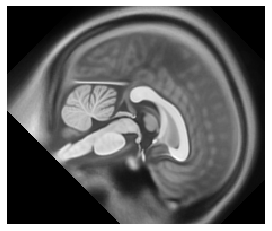

In [6]:
"""
    Apply affine transformation to moving image
"""
# Let's create an empty array of the same size of the fixed image
# to fill in. This will allow us to interpolate over the grid of
# the fixed image
#
# In this particular case, this doesn't matter too much since the
# moving and fixed image are of the same dimensions/resolution.
# However, this does matter in the case of images of differing
# dimensions/resolutions
new_moving_img = np.zeros(fixed_img.shape)

# Now let's apply an affine transform to the moving image
#
# We are going to use the affine_transform function from the scipy
# library. Internally, this use a b-spline interpolation method
# to interpolate between voxel values.
#
# If you read the documentation for the function, you'll note that
# it accepts the inverse of the forward transform for the reasons
# stated above.
affine_transform(
    mover_img.get_fdata(),
    affine_mat,
    output=new_moving_img
)

# display the new image with the affine transform applied
display_slice(mover_img.get_fdata())

In [7]:
"""
    Calculate gradient
"""
# Now we need a way to calculate the gradient to solve the
# optimization problem
#
# We can use the analytical gradient solution for the L2 objective
# function, and code an expression for the gradient
# given any affine matrix
def calculate_gradient(affine_mat: np.array):
    # calculate residual term
    residual = mover_img.get_fdata().ravel() - fixed_img.get_fdata().ravel()
    
    # grab the mover image header
    mover_dim = [1,1,1]
    
    # calculate gradient
    gradient_img = np.gradient(mover_img.get_fdata(), mover_dim)
    
    # calculate position gradient